In [2]:
# All the Necessary Libraries used

import pandas as pd
import gurobipy as gp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns

In [4]:
# Loading the CSV file
file_path = 'price_demand_data.csv'
data = pd.read_csv(file_path)

# First few rows of the data
data.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


# Specific 1 - Fitting a Linear Regression Model to the Dataset

In [14]:
# Separate the features and target variable
X = data[['price']]  # Feature (price) as a 2D DataFrame
y = data['demand']  # Target (demand)

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Extract model coefficients for interpretation
beta_0 = model.intercept_  # Intercept (beta_0)
beta_1 = model.coef_[0]  # Slope (beta_1)


# Extract and print model coefficients
print(f"Intercept (beta_0): {model.intercept_}")
print(f"Slope (beta_1): {model.coef_[0]}")


Intercept (beta_0): 1924.7175435291088
Slope (beta_1): -1367.7125241625981


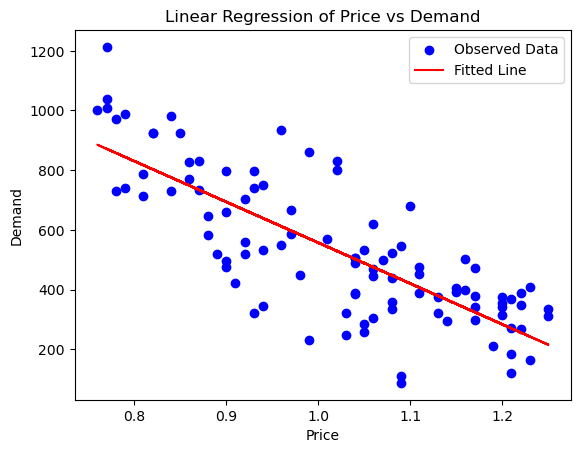

In [16]:
# To Visualize the result

# Plot the data points and the fitted line
plt.scatter(X, y, color='blue', label='Observed Data')  # Scatter plot of actual data
plt.plot(X, model.predict(X), color='red', label='Fitted Line')  # Regression line
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Linear Regression of Price vs Demand')
plt.legend()
plt.show()


# Specific 2 - Let c=0.5, g=0.75, and t=0.15. Using the residuals, assume the price is p=1 and generate demand data.

In [19]:
#  Generating demand data for price p = 1 using residuals
p = 1  # Given price
c = 0.5  # Cost per unit
g = 0.75  # Cost of rushed order
t = 0.15  # Disposal cost

# Calculate predicted demand based on the fitted model
y_pred = model.predict(X)

# Calculate residuals (difference between actual and predicted demand)
residuals = y - y_pred

# Print a few residuals for verification
print("Residuals (first 6 values):")
print(residuals[:6])

# Generate new demand data for price p = 1 using the residuals
new_demand_data = beta_0 + beta_1 * p + residuals

# Display the new demand data in a DataFrame
demand_df = pd.DataFrame({'Price': [p] * len(new_demand_data), 'Generated Demand': new_demand_data})
print(demand_df.head())

Residuals (first 6 values):
0   -205.619393
1     22.515227
2    -84.785389
3   -108.067771
4    116.743975
5   -103.870399
Name: demand, dtype: float64
   Price  Generated Demand
0      1        351.385626
1      1        579.520247
2      1        472.219630
3      1        448.937249
4      1        673.748994


# Specific 3 - Solve the optimal quantity to produce when p=1 (Not a Quadratic, just an LP)

In [33]:
import gurobipy as gp
from gurobipy import GRB

# Solving the optimal quantity to produce when p = 1 using Gurobi
n = len(new_demand_data)  # Number of demand data points

# Initialize the Gurobi model
model = gp.Model("newsvendor_lp")

# Disable Gurobi output
model.Params.outputFlag = 0

# Add decision variable for quantity to produce
q = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q")

# Add auxiliary variables for profit per scenario
h = model.addVars(n, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="h")

# Set the objective function: maximize average profit
model.setObjective(gp.quicksum(h[i] for i in range(n)) / n, GRB.MAXIMIZE)

# Add constraints for each demand scenario
for i in range(n):
    model.addConstr(h[i] <= p * new_demand_data.iloc[i] - c * q, name=f"profit_constraint_1_{i}")
    model.addConstr(h[i] <= p * q - c * q, name=f"profit_constraint_2_{i}")

# Optimize the model
model.optimize()

# Print the optimal quantity to produce
if model.status == GRB.OPTIMAL:
    optimal_q = q.X
    expected_profit = model.objVal
    print(f"Optimal quantity to produce (q): {optimal_q:.2f}")
    print(f"Expected Profit: ${expected_profit:.2f}")
else:
    print("Gurobi optimization did not converge to a solution.")


Optimal quantity to produce (q): 569.90
Expected Profit: $219.28


# Specific 4 - Now let price impact demand and solve either the resulting QCP or QP. What are the optimal price and quantity to print?

In [31]:
import gurobipy as gp
from gurobipy import GRB

# Using the Second Extension: Solve for the optimal price and quantity jointly (QCP)
# Initialize the Gurobi model for the second extension
model_qcp = gp.Model("newsvendor_second_extension")

# Disable Gurobi output
model_qcp.Params.outputFlag = 0

# Add decision variables for price and quantity
p_qcp = model_qcp.addVar(lb=0, vtype=GRB.CONTINUOUS, name="p_qcp")  # Price
q_qcp = model_qcp.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q_qcp")  # Quantity to produce

# Add auxiliary variables for profit per scenario
h_qcp = model_qcp.addVars(n, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="h_qcp")

# Set the objective function: maximize average profit
model_qcp.setObjective(gp.quicksum(h_qcp[i] for i in range(n)) / n, GRB.MAXIMIZE)

# Add constraints for each demand scenario considering the quadratic price impact on demand
for i in range(n):
    # Demand as a function of price
    demand_i = beta_0 + beta_1 * p_qcp + residuals[i]
    
    # Define max_excess_qcp and max_shortfall_qcp using auxiliary constraints
    max_excess = model_qcp.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"max_excess_{i}")
    max_shortfall = model_qcp.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"max_shortfall_{i}")

    model_qcp.addConstr(max_excess >= q_qcp - demand_i, name=f"max_excess_qcp_constraint_{i}")
    model_qcp.addConstr(max_shortfall >= demand_i - q_qcp, name=f"max_shortfall_qcp_constraint_{i}")

    # Profit for each scenario with quadratic pricing impact
    model_qcp.addConstr(h_qcp[i] == p_qcp * demand_i - c * q_qcp - g * max_shortfall - t * max_excess, name=f"qcp_profit_constraint_{i}")

# Optimize the model for the second extension
model_qcp.optimize()

# Print the optimal price and quantity for the second extension
if model_qcp.status == GRB.OPTIMAL:
    optimal_p_qcp = p_qcp.X
    optimal_q_qcp = q_qcp.X
    optimal_profit_qcp = model_qcp.objVal
    print(f"Optimal price (p): {optimal_p_qcp:.2f}")
    print(f"Optimal quantity to produce (q): {optimal_q_qcp:.2f}")
    print(f"Expected Profit: ${optimal_profit_qcp:.2f}")
else:
    print("Gurobi optimization for the second extension did not converge to a solution.")


Optimal price (p): 0.95
Optimal quantity to produce (q): 535.31
Expected Profit: $234.42


# Specific 6 - To know how sensitive the optimal price and quantity are to our data set. Take a bootstrap sample of the original dataset. Go back and fit new beta’s to the new bootstrapped dataset and redo step 4. Find the optimal price and quantity.

In [62]:
from sklearn.utils import resample
import gurobipy as gp
from gurobipy import GRB

# Step 6: Bootstrap Sampling and Re-fitting the Model (Question 6)
n_iterations = 10  # Number of bootstrap samples to take
optimal_prices = []
optimal_quantities = []
expected_profits = []

for iteration in range(n_iterations):
    # Take a bootstrap sample from the original dataset
    X_resampled, y_resampled = resample(X, y, replace=True)

    # Fit a linear regression model to the bootstrapped dataset
    model_bootstrap = LinearRegression()
    model_bootstrap.fit(X_resampled, y_resampled)

    # Extract new beta values
    beta_0_bootstrap = model_bootstrap.intercept_
    beta_1_bootstrap = model_bootstrap.coef_[0]

    # Generate new demand data using the residuals and new betas
    y_pred_bootstrap = model_bootstrap.predict(X_resampled)
    residuals_bootstrap = y_resampled - y_pred_bootstrap
    new_demand_data_bootstrap = beta_0_bootstrap + beta_1_bootstrap * 1 + residuals_bootstrap

    # Initialize the Gurobi model for the second extension
    model_qcp_bootstrap = gp.Model("newsvendor_second_extension_bootstrap")

    # Suppress Gurobi output
    model_qcp_bootstrap.Params.outputFlag = 0

    # Add decision variables for price and quantity
    p_qcp_bootstrap = model_qcp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name="p_qcp_bootstrap")  # Price
    q_qcp_bootstrap = model_qcp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q_qcp_bootstrap")  # Quantity to produce

    # Add auxiliary variables for profit per scenario
    n_bootstrap = len(new_demand_data_bootstrap)
    h_qcp_bootstrap = model_qcp_bootstrap.addVars(n_bootstrap, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="h_qcp_bootstrap")

    # Set the objective function: maximize average profit
    model_qcp_bootstrap.setObjective(gp.quicksum(h_qcp_bootstrap[i] for i in range(n_bootstrap)) / n_bootstrap, GRB.MAXIMIZE)

    # Add constraints for each demand scenario considering the quadratic price impact on demand
    for i in range(n_bootstrap):
        # Demand as a function of price
        demand_i_bootstrap = beta_0_bootstrap + beta_1_bootstrap * p_qcp_bootstrap + residuals_bootstrap.iloc[i]
        
        # Define auxiliary variables for max terms
        max_excess = model_qcp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"max_excess_{i}")
        max_shortfall = model_qcp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"max_shortfall_{i}")

        model_qcp_bootstrap.addConstr(max_excess >= q_qcp_bootstrap - demand_i_bootstrap, name=f"max_excess_qcp_constraint_{i}")
        model_qcp_bootstrap.addConstr(max_shortfall >= demand_i_bootstrap - q_qcp_bootstrap, name=f"max_shortfall_qcp_constraint_{i}")

        # Profit for each scenario with quadratic pricing impact
        model_qcp_bootstrap.addConstr(h_qcp_bootstrap[i] == p_qcp_bootstrap * demand_i_bootstrap - c * q_qcp_bootstrap - g * max_shortfall - t * max_excess, name=f"qcp_profit_constraint_bootstrap_{i}")

    # Optimize the model for the second extension with bootstrap data
    model_qcp_bootstrap.optimize()

    # Store the optimal price, quantity, and expected profit for this bootstrap iteration
    if model_qcp_bootstrap.status == GRB.OPTIMAL:
        optimal_prices.append(p_qcp_bootstrap.X)
        optimal_quantities.append(q_qcp_bootstrap.X)
        expected_profits.append(model_qcp_bootstrap.objVal)
        print(f"Iteration {iteration + 1}: Optimal price (p): {p_qcp_bootstrap.X:.2f}, Optimal quantity (q): {q_qcp_bootstrap.X:.2f}, Expected Profit: ${model_qcp_bootstrap.objVal:.2f}")
    else:
        print(f"Iteration {iteration + 1}: Gurobi optimization did not converge to a solution.")

# Display summary statistics for optimal prices, quantities, and expected profits if desired


Iteration 1: Optimal price (p): 0.93, Optimal quantity (q): 591.35, Expected Profit: $241.04
Iteration 2: Optimal price (p): 0.97, Optimal quantity (q): 528.70, Expected Profit: $240.87
Iteration 3: Optimal price (p): 0.99, Optimal quantity (q): 506.37, Expected Profit: $237.20
Iteration 4: Optimal price (p): 0.95, Optimal quantity (q): 555.45, Expected Profit: $245.53
Iteration 5: Optimal price (p): 0.96, Optimal quantity (q): 502.32, Expected Profit: $227.48
Iteration 6: Optimal price (p): 0.97, Optimal quantity (q): 500.76, Expected Profit: $238.10
Iteration 7: Optimal price (p): 0.94, Optimal quantity (q): 594.09, Expected Profit: $243.99
Iteration 8: Optimal price (p): 0.94, Optimal quantity (q): 540.75, Expected Profit: $230.27
Iteration 9: Optimal price (p): 0.96, Optimal quantity (q): 568.24, Expected Profit: $251.53
Iteration 10: Optimal price (p): 0.96, Optimal quantity (q): 500.39, Expected Profit: $218.37


# Specific 7 - Repeat this process of getting new bootstrapped data, fitting new betas to the newly simulated data and finding the optimal price/quantity many times. Make histograms of the optimal price and quantity. Make a scatterplot with histograms on the x and y axis for this. Make a histogram of expectation of profits.

In [66]:
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from sklearn.utils import resample

# Step 7: Repeat Bootstrap Process and Visualization (Question 7)
# Perform multiple bootstraps to find optimal price, quantity, and profit distributions
n_iterations_q7 = 50  # Number of bootstrap samples for better analysis
optimal_prices_q7 = []
optimal_quantities_q7 = []
expected_profits_q7 = []

for iteration in range(n_iterations_q7):
    # Take a bootstrap sample from the original dataset
    X_resampled, y_resampled = resample(X, y, replace=True)

    # Fit a linear regression model to the bootstrapped dataset
    model_bootstrap = LinearRegression()
    model_bootstrap.fit(X_resampled, y_resampled)

    # Extract new beta values
    beta_0_bootstrap = model_bootstrap.intercept_
    beta_1_bootstrap = model_bootstrap.coef_[0]

    # Generate new demand data using the residuals and new betas
    y_pred_bootstrap = model_bootstrap.predict(X_resampled)
    residuals_bootstrap = y_resampled - y_pred_bootstrap
    new_demand_data_bootstrap = beta_0_bootstrap + beta_1_bootstrap * 1 + residuals_bootstrap

    # Initialize the Gurobi model for the second extension
    model_qcp_bootstrap = gp.Model("newsvendor_second_extension_bootstrap_q7")

    # Suppress Gurobi output
    model_qcp_bootstrap.Params.outputFlag = 0

    # Add decision variables for price and quantity
    p_qcp = model_qcp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name="p_qcp")  # Price
    q_qcp = model_qcp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q_qcp")  # Quantity to produce

    # Add auxiliary variables for profit per scenario
    n_bootstrap = len(new_demand_data_bootstrap)
    h_qcp = model_qcp_bootstrap.addVars(n_bootstrap, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="h_qcp")

    # Set the objective function: maximize average profit
    model_qcp_bootstrap.setObjective(gp.quicksum(h_qcp[i] for i in range(n_bootstrap)) / n_bootstrap, GRB.MAXIMIZE)

    # Add constraints for each demand scenario considering the quadratic price impact on demand
    for i in range(n_bootstrap):
        # Demand as a function of price
        demand_i = beta_0_bootstrap + beta_1_bootstrap * p_qcp + residuals_bootstrap.iloc[i]

        # Define auxiliary variables for max terms
        max_excess = model_qcp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"max_excess_{i}")
        max_shortfall = model_qcp_bootstrap.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"max_shortfall_{i}")

        model_qcp_bootstrap.addConstr(max_excess >= q_qcp - demand_i, name=f"max_excess_constraint_{i}")
        model_qcp_bootstrap.addConstr(max_shortfall >= demand_i - q_qcp, name=f"max_shortfall_constraint_{i}")

        # Profit for each scenario with quadratic pricing impact
        model_qcp_bootstrap.addConstr(h_qcp[i] == p_qcp * demand_i - c * q_qcp - g * max_shortfall - t * max_excess, name=f"profit_constraint_{i}")

    # Optimize the model for the second extension with bootstrap data
    model_qcp_bootstrap.optimize()

    # Store the optimal price, quantity, and expected profit for this bootstrap iteration
    if model_qcp_bootstrap.status == GRB.OPTIMAL:
        optimal_prices_q7.append(p_qcp.X)
        optimal_quantities_q7.append(q_qcp.X)
        expected_profits_q7.append(model_qcp_bootstrap.objVal)



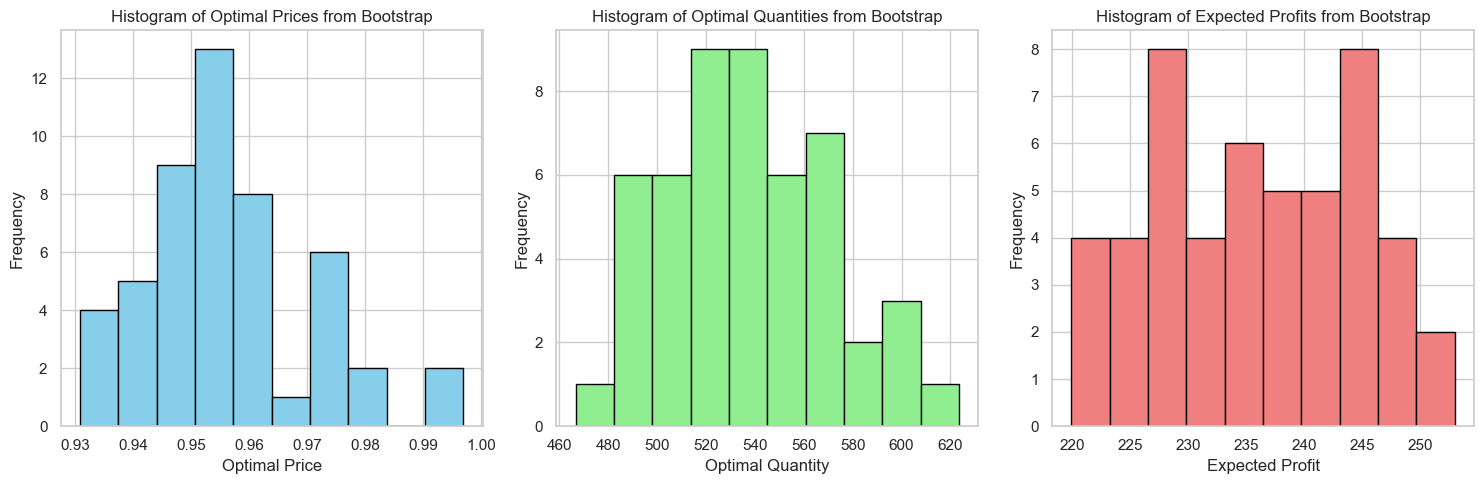

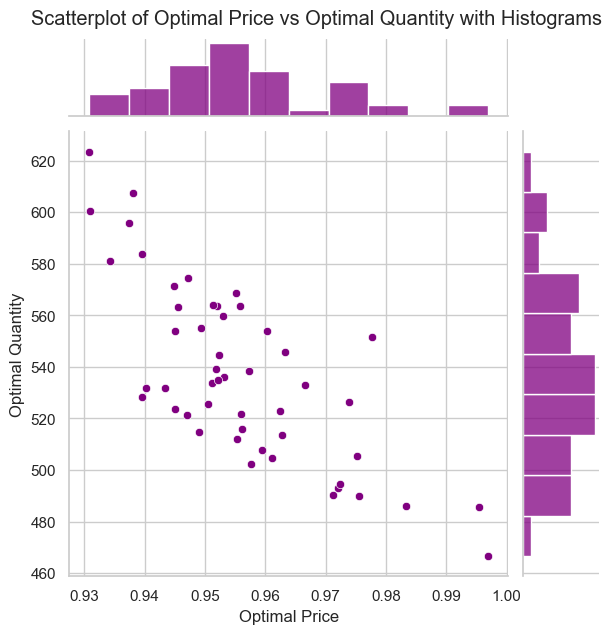

In [82]:
# Step 7: Visualization of Bootstrap Results (Question 7)
# Histograms of optimal prices, quantities, and expected profits
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(optimal_prices_q7, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Optimal Price')
plt.ylabel('Frequency')
plt.title('Histogram of Optimal Prices from Bootstrap')

plt.subplot(1, 3, 2)
plt.hist(optimal_quantities_q7, bins=10, color='lightgreen', edgecolor='black')
plt.xlabel('Optimal Quantity')
plt.ylabel('Frequency')
plt.title('Histogram of Optimal Quantities from Bootstrap')

plt.subplot(1, 3, 3)
plt.hist(expected_profits_q7, bins=10, color='lightcoral', edgecolor='black')
plt.xlabel('Expected Profit')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Profits from Bootstrap')

plt.tight_layout()
plt.show()

# Scatter plot with histograms on x and y axis for optimal price vs quantity
sns.jointplot(x=optimal_prices_q7, y=optimal_quantities_q7, kind="scatter", marginal_kws=dict(bins=10, fill=True), color='purple')
plt.xlabel('Optimal Price')
plt.ylabel('Optimal Quantity')
plt.suptitle('Scatterplot of Optimal Price vs Optimal Quantity with Histograms', y=1.02)
plt.show()

# A Standard NVM when p is dynamic

In [73]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Load the data
data = pd.read_csv('price_demand_data.csv')

# Define model parameters
c = 0.5  # Cost per unit

# Standard NV model
standard_nv = gp.Model("Standard_NVM")

# Suppress Gurobi output
standard_nv.Params.OutputFlag = 0

# Add decision variable for production quantity
q_std = standard_nv.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q_std")

# Add auxiliary variables to represent min(q_std, demand)
min_vars = standard_nv.addVars(len(data), lb=0, vtype=GRB.CONTINUOUS, name="min_vars")

# Set the objective function: maximize average profit
standard_nv.setObjective(
    gp.quicksum(data['price'][i] * min_vars[i] - q_std * c for i in range(len(data))) / len(data), GRB.MAXIMIZE
)

# Add constraints for min(q_std, demand) representation
for i in range(len(data)):
    standard_nv.addConstr(min_vars[i] <= q_std, name=f"min_constraint_1_{i}")
    standard_nv.addConstr(min_vars[i] <= data['demand'][i], name=f"min_constraint_2_{i}")

# Optimize the model
standard_nv.optimize()

# Print the results of the standard NVM
print(f"Standard NV model optimal quantity: {q_std.X:.2f}")
print(f"Standard NV model expected profit: {standard_nv.objVal:.2f}")
print()

# Extended model results
print(f"Extended model optimal price: {optimal_p_qcp:.2f}")
print(f"Extended model optimal quantity: {optimal_q_qcp:.2f}")
print(f"Extended model expected profit: {model_qcp.objVal:.2f}")

Standard NV model optimal quantity: 469.00
Standard NV model expected profit: 167.64

Extended model optimal price: 0.95
Extended model optimal quantity: 535.31
Extended model expected profit: 234.42


# Extension 1 - Rush Disposal

In [89]:
import gurobipy as gp
from gurobipy import GRB

# Defining the price, cost, rush, and disposal fees (from specific 2) 
p = 1  # Price per unit (ensure this is defined correctly)
c = 0.5  # Cost per unit
g = 0.75  # Rush cost per unit
t = 0.15  # Disposal cost per unit

# Initialize the Gurobi model for Extension 1
model_ext1 = gp.Model("newsvendor_extension_1")

# Suppress Gurobi output
model_ext1.Params.OutputFlag = 0

# Assuming new_demand_data is available with demand values
n = len(new_demand_data)

# Add decision variable for quantity to produce
q_ext1 = model_ext1.addVar(lb=0, vtype=GRB.CONTINUOUS, name="q_ext1")

# Add auxiliary variables for profit per scenario and max terms for excess and shortfall
h_ext1 = model_ext1.addVars(n, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="h_ext1")
max_excess = model_ext1.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="max_excess")  # (q - D_i)+
max_shortfall = model_ext1.addVars(n, lb=0, vtype=GRB.CONTINUOUS, name="max_shortfall")  # (D_i - q)+

# Set the objective function: maximize average profit considering rush and disposal costs
model_ext1.setObjective(gp.quicksum(h_ext1[i] for i in range(n)) / n, GRB.MAXIMIZE)

# Add constraints for each demand scenario considering rush and disposal costs
for i in range(n):
    demand_i = new_demand_data[i]

    # Define max_excess and max_shortfall using constraints
    model_ext1.addConstr(max_excess[i] >= q_ext1 - demand_i, name=f"max_excess_constraint_{i}")
    model_ext1.addConstr(max_shortfall[i] >= demand_i - q_ext1, name=f"max_shortfall_constraint_{i}")

    # Profit constraint for each scenario
    model_ext1.addConstr(
        h_ext1[i] == p * demand_i - c * q_ext1 - g * max_shortfall[i] - t * max_excess[i],
        name=f"profit_constraint_{i}"
    )

# Optimize the model for Extension 1
model_ext1.optimize()

# Print the optimal quantity to produce for Extension 1
if model_ext1.status == GRB.OPTIMAL:
    optimal_q_ext1 = q_ext1.X
    optimal_profit_ext1 = model_ext1.objVal
    print(f"Optimal quantity to produce for Extension 1 (q_ext1): {optimal_q_ext1:.2f}")
    print(f"Expected Profit: ${optimal_profit_ext1:.2f}")
else:
    print("Gurobi optimization for Extension 1 did not converge to a solution.")


Optimal quantity to produce for Extension 1 (q_ext1): 471.87
Expected Profit: $231.48
